# Chapter 2 (3-period lived Agents with Exogenous Labor Supply)

Code is based on OG-USA.

In [2]:
import numpy as np 
import time 
import scipy.optimize as opt
from matplotlib import pyplot as plt
import scipy.linalg as la

In [6]:
# parameters for the model
beta = 0.96 ** 20
delta = 1 - (1 - 0.05) ** 20
sigma = 3
A = 1
alpha = 0.35

nvec = np.array([1, 1, 0.2])
L = np.sum(nvec)
SS_tol = 1e-15

In [7]:
def get_L(nvec):
    L = np.sum(nvec)
    return L

def get_K(bvec):
    K = np.sum(bvec)
    return K

def get_r(K, L, params):
    alpha, A, delta = params
    r = alpha * A * (L / K) ** (1 - alpha) - delta
    return r
    
def get_w(K, L, params):
    alpha, A = params
    w = (1 - alpha) * A * (K / L) ** alpha
    return w

def get_Y(K, L, params):
    alpha, A = params
    Y = A * (K ** alpha) * (L ** (1 - alpha))
    return Y

def get_C(cvec):
    C = np.sum(cvec)
    return C

## Exercise 2.1

In [8]:
def feasible(f_params, bvec_guess):
    '''
    input
        f_params: (nvec, A, alpha, delta)
        bvec_guess: guess for steady-state savings vector in the form np.array([scalar, scalar])
    '''
    nvec, A, alpha, delta = f_params
    b2, b3 = bvec_guess
    n1, n2, n3 = nvec
    
    b_cnstr = np.full((2), False, dtype=bool)
    c_cnstr = np.full((3), False, dtype=bool)
    K_cnstr = np.full((1), False, dtype=bool)
    
    K = get_K(bvec_guess)
    K_cnstr = K < 0
    L = get_L(nvec)
    
    r_params = (alpha, A, delta)
    r = get_r(K, L, r_params)
    w_params = (alpha, A)
    w = get_w(K, L, w_params)
    
    # HH age-specific budget constraint
    c_cnstr[0] = n1 * w - b2 < 0
    c_cnstr[1] = n2 * w + (1 + r) * b2 - b3 < 0
    c_cnstr[2] = n3 * w + (1 + r) * b3 < 0
    
    if c_cnstr[0]:
        b_cnstr[0] = True
    if c_cnstr[1]:
        b_cnstr[1] = b_cnstr[2] = True
    if c_cnstr[2]:
        b_cnstr[2] = True
    
    return b_cnstr, c_cnstr, K_cnstr

#### Part a

In [12]:
f_params = np.array([nvec, A, alpha, delta])
bvec_guess = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b constraint: ", b_cnstr)
print("c constraint: ", c_cnstr)
print("K constraint: ", K_cnstr)

b constraint:  [ True False]
c constraint:  [ True False False]
K constraint:  False


#### Part b

In [13]:
bvec_guess = np.array([0.06, -0.001])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b constraint: ", b_cnstr)
print("c constraint: ", c_cnstr)
print("K constraint: ", K_cnstr)

b constraint:  [False False]
c constraint:  [False False False]
K constraint:  False


#### Part c

In [14]:
bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b constraint: ", b_cnstr)
print("c constraint: ", c_cnstr)
print("K constraint: ", K_cnstr)

b constraint:  [False False]
c constraint:  [False False False]
K constraint:  False


## Exercise 2.2

In [16]:
def get_cons(bvec, args):  
    '''
    bvec: savings of remaining periods of life
    '''
    nvec, r, w = args
    bs = np.append(0.0, bvec)  # because inherit 0 savings when born
    bsp = np.append(bvec, 0.0)  # because leave 0 savings before end of life
    cvec = (1 + r) * bs + w * nvec - bsp
    
    return cvec

In [17]:
def get_MU_c(cvec, sigma, graph=True):

    MU_c = cvec ** (-sigma)
    return MU_c

In [18]:
def get_b_EE(cvec, args):
    
    beta, sigma, r = args
    mu_c = get_MU_c(cvec[:-1], sigma)
    mu_cp = get_MU_c(cvec[1:], sigma)
    
    EE_b_errs = (beta * (1 + r) * mu_cp) - mu_c
    return EE_b_errs

In [19]:
def get_SS_EE(bvec, *args):
    
    nvec, beta, sigma, A, alpha, delta = args
    K = get_K(bvec)
    L = get_L(nvec)
    r_params = (alpha, A, delta)
    r = get_r(K, L, r_params)
    w_params = (alpha, A)
    w = get_w(K, L, w_params)
    c_args = (nvec, r, w)
    cvec = get_cons(bvec, c_args)
    b_args = (beta, sigma, r)
    EE = get_b_EE(cvec, b_args)
    
    return EE

In [20]:
def get_SS_graphs(c_ss, b_ss):
    
    S = len(c_ss)
    b_ss2 = np.append(0.0, b_ss)
    age_pers = np.arange(1, S+1)
    
    plt.plot(age_pers, c_ss, marker='D', label='Consumption')
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.xlabel(r'Age $s$')
    plt.ylabel(r'Units of consumption')
    plt.xlim((0, S + 1))
    plt.legend(loc='upper left')
    plt.show()
    
    plt.plot(age_pers, b_ss2, marker='D', label='Savings')
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.xlabel(r'Age $s$')
    plt.ylabel(r'Units of consumption')
    plt.xlim((0, S + 1))
    plt.legend(loc='upper left')
    plt.show()

In [21]:
def get_SS(params, bvec_guess, SS_graphs):
    
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    
    start_time = time.clock()
    
    EE_args = (nvec, beta, sigma, A, alpha, delta)
    results_EE = opt.root(get_SS_EE, bvec_guess, args=EE_args, tol=SS_tol)
    b_ss = results_EE.x
    EulErr_ss = results_EE.fun
    
    K_ss = get_K(b_ss)
    r_params = (alpha, A, delta)
    r_ss = get_r(K_ss, L, r_params)
    w_params = (alpha, A)
    w_ss = get_w(K_ss, L, w_params)
    c_args = (nvec, r_ss, w_ss)
    c_ss = get_cons(b_ss, c_args)
    
    Y_params = (alpha, A)
    Y_ss = get_Y(K_ss, L, Y_params)
    C_ss = get_C(c_ss)
    
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.clock() - start_time
    
    ss_output = {
        'b_ss': b_ss, 
        'c_ss': c_ss, 
        'w_ss': w_ss, 
        'r_ss': r_ss,
        'K_ss': K_ss, 
        'Y_ss': Y_ss, 
        'C_ss': C_ss,
        'EulErr_ss': EulErr_ss,
        'RCerr_ss': RCerr_ss,
        'ss_time': ss_time
    }
    
    if SS_graphs: 
        get_SS_graphs(c_ss, b_ss)
        
    return ss_output

In [23]:
# parameters for the model
S = 3
beta = .442
delta = .6415
sigma = 3
A = 1
alpha = 0.35

s = np.round(2 * S / 3)
nvec1 = np.ones(int(s)) * 1
nvec2 = np.ones(int(S - s)) * 0.2
nvec = np.concatenate((nvec1, nvec2), axis=None)
L = np.sum(nvec)

bvec_guess = np.ones(S - 1) * 0.003
SS_tol = 1e-8
SS_graphs=True

#### Part a, b

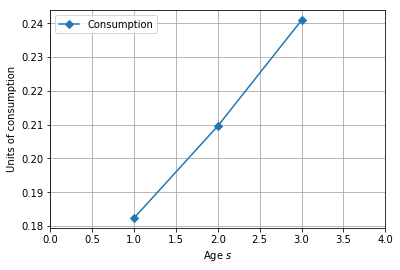

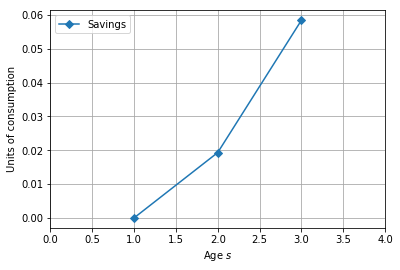

{'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': array([0.18241213, 0.20961468, 0.24087387]),
 'w_ss': 0.20172465739052575,
 'r_ss': 2.433062339127069,
 'K_ss': 0.07772362575316386,
 'Y_ss': 0.6827603788602411,
 'C_ss': 0.6329006729395864,
 'EulErr_ss': array([ 1.39266376e-12, -2.62900812e-12]),
 'RCerr_ss': 8.326672684688674e-17,
 'ss_time': 0.005984000000000211}

In [24]:
bvec_guess = [.1, .1]
params = (beta, sigma, nvec, L, A, alpha, delta, SS_tol)
get_SS(params, bvec_guess, SS_graphs)

#### Part c

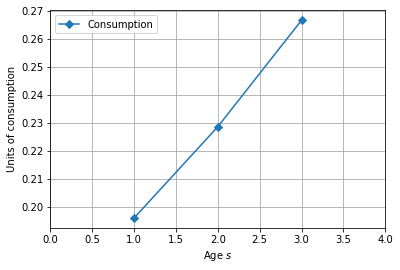

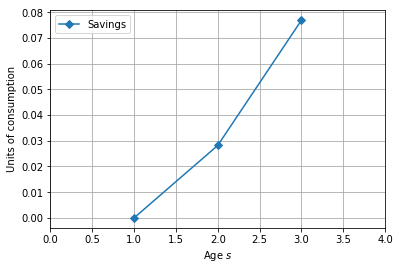

{'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': array([0.19597528, 0.22861594, 0.26669307]),
 'w_ss': 0.22415219593351624,
 'r_ss': 1.8863765057388953,
 'K_ss': 0.10504237022470767,
 'Y_ss': 0.7586689708519012,
 'C_ss': 0.6912842903527512,
 'EulErr_ss': array([ 7.52825713e-09, -4.26037161e-09]),
 'RCerr_ss': 6.938893903907228e-17,
 'ss_time': 0.005194000000000365}

In [25]:
beta = 0.55
bvec_guess = np.ones(S - 1) * 0.003
params = ((beta, sigma, nvec, L, A, alpha, delta, SS_tol))
get_SS(params, bvec_guess, SS_graphs)

## Exercise 2.3

In [26]:
def mu_cons(c, sigma):
    '''
    Assume CRRA Utility function. 
    '''
    return c ** (-sigma)

In [27]:
def get_cvec(nvec, w1, w2, w3, r2, r3, b22, b33):
    
    c1 = nvec[0] * w1 - b22
    c2 = nvec[1] * w2 + (1 + r2) *  b22 - b33
    c3 = (1 + r3) * b33 + nvec[2] * w3
    
    return c1, c2, c3

In [28]:
def firstdoughnutring(b32, *args):
    
    # Consider as if period 1 agent: 
    w1, w2, r1, r2, b21, nvec, sigma = args    
    c1, c2, c3 = get_cvec(nvec, 1, w1, w2, r1, r2, b21, b32)
    
    EE = mu_cons(c2, sigma) - beta * (1 + r2) \
            * mu_cons(c3, sigma)
    
    return EE

In [29]:
def twist_doughnut(bvec, *args):
    
    # Consider as if period 1 agent: 
    w1, w2, w3, r2, r3, nvec, sigma = args
    b22, b33 = bvec
    c1, c2, c3 = get_cvec(nvec, w1, w2, w3, r2, r3, b22, b33)
    
    EE1 = mu_cons(c1, sigma) - beta * (1 + r2) * mu_cons(c2, sigma)
    EE2 = mu_cons(c2, sigma) - beta * (1 + r3) * mu_cons(c3, sigma)
    
    return np.array([EE1, EE2])

In [30]:
def get_TPI_graphs(K_path, K_bar, w_path, w_bar, r_path, r_bar):
    
    S = len(K_path)
    age = np.arange(1, S-3)
    
    plt.plot(K_path[:-4], marker='D', label='Aggregate Capital Stock')
    plt.hlines(K_bar, -1, T, label='SS Capital')
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Level')
    plt.title('Equilibrium Time Path of Aggregate Capital Stock')
    plt.legend(loc='upper left')
    plt.show()
    
    plt.plot(w_path[:-4], marker='D', label='Wage')
    plt.hlines(w_bar, -1, T, label='SS Wage')
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Level')
    plt.title('Equilibrium Time Path of Wage')
    plt.legend(loc='upper left')
    plt.show()
    
    plt.plot(r_path[:-4], marker='D', label='Interest Rate')
    plt.hlines(r_bar, -1, T, label='SS Interest Rate')
    plt.grid(b=True, which='major', color='0.65', linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Level')
    plt.title('Equilibrium Time Path of Interest Rate')
    plt.legend(loc='upper left')
    plt.show()

In [31]:
def get_TPI(params, T, SS_tol, TPI_tol, TPI_graph=True):
    
    beta, sigma, xi, nvec, L, A, alpha, delta, SS_tol = params
    start_time = time.clock()
    
    # Step 1: Solve for SS b2_bar, b3_bar => K_bar, r_bar, w_bar
    #params_ss = (beta, sigma, nvec, L, A, alpha, delta, SS_tol)
    params_ss = (beta, sigma, nvec, L, A, alpha, delta, SS_tol)
    
    bvec_guess = (0.005, 0.005)
    output = get_SS(params_ss, bvec_guess, SS_graphs=False)
    K_bar = output['K_ss']
    r_bar = output['r_ss']
    w_bar = output['w_ss']
    b2_bar, b3_bar = output['b_ss']
    
    # Step 2: Given guess T, guess K_path
    b21 = 0.8 * b2_bar
    b31 = 1.1 * b3_bar
    bvec1 = np.array([b21, b31])
    K1 = np.sum(bvec1)
    K_path = np.linspace(K1, K_bar, T+3)
    
    # Step 3: Given guess K_path, => r_path, w_path
    r_params = alpha, A, delta 
    r_path = get_r(K_path, L, r_params)  
    w_params = alpha, A
    w_path = get_w(K_path, L, w_params)
    
    # Step 4: solve HH solution of [b_{2,t+1}, b_{3,t+1}] from t=1 to T
    bmat = np.zeros((T+3+1, 2))
    bmat[0,:] = (b21, b31)
    EulErrs = np.zeros((T+3+1, 2))
    
    ## solve for b32
    w1, w2, r1, r2 = w_path[0], w_path[1], r_path[0], r_path[1]
    args = (w1, w2, r1, r2, b21, nvec, sigma)
    b32_guess = 0
    doghnut1 = opt.root(firstdoughnutring, b32_guess, args=args, tol=TPI_tol)
    bmat[1, 1] = doghnut1.x 
    EulErrs[1, 1] = doghnut1.fun
    
    ## Solve for rest through doughnut method
    iteration = 1
    #K_path_new = K_path
    max_iter = 100
    diff = 1000
    
    while (diff > TPI_tol) and (iteration < max_iter):
        #print('iteration :', iteration)
        for t in range(T):
            
            w1, w2, w3, r2, r3 = w_path[t], w_path[t+1], w_path[t+2], \
                r_path[t+1], r_path[t+2]
            args = (w1, w2, w3, r2, r3, nvec, sigma)
            bvec_guess = (0, 0)
            doghnut2 = opt.root(twist_doughnut, bvec_guess, args=args)
            b2t1, b2t2 = doghnut2.x
            bmat[t+1, 0] = b2t1
            bmat[t+2, 1] = b2t2
            EulErrs[t] = doghnut2.fun
            
        ## Maximum absolute values of all EulErrs across entire time path:
        maxEulErrs_TPI = np.abs(EulErrs).max(axis = 0)
        K_path_updated = bmat[:-1].sum(axis=1)
        diff = la.norm(K_path_updated - K_path, 2)
        #print('diff :', diff)

        ## New transition path
        K_path = xi * K_path_updated + (1 - xi) * K_path

        ## Update r_path, w_path based on K_path_new
        r_path = get_r(K_path, L, r_params)
        w_path = get_w(K_path, L, w_params)

        iteration += 1

    TPI_time = time.clock() - start_time
    
    Y_params = (alpha, A)
    Y_path = get_Y(K_path, L, Y_params)
    
    b2_path = bmat[:, 0][:-1]
    b3_path = bmat[:, 1][:-1]
    n1, n2, n3 = nvec
    c1_path = n1 * w_path - b2_path  # Consumption in period 1
    c2_path = n2 * w_path + (1 + r_path) * b2_path - b3_path  # Consumption in period 2
    c3_path = n3 * w_path + (1 + r_path) * b3_path  # Consumption in period 3
    c_path = np.array([c1_path, c2_path, c3_path])
    C_path = np.sum(c_path, axis = 0)
    
    RCerrPath = Y_path[:-1] - C_path[:-1] - K_path[1:] + (1 - delta) * K_path[:-1]
    
    TPI_output = {
        'b_path': bmat, 
        'c_path': c_path, 
        'w_path': w_path, 
        'r_path': r_path,
        'K_path': K_path, 
        'Y_path': Y_path, 
        'C_path': C_path,
        'K_bar': K_bar,
        'maxEulErrs_TPI': maxEulErrs_TPI, 
        'RCerrPath': RCerrPath,
        'tpi_time': TPI_time
    }

    if TPI_graph:
        get_TPI_graphs(K_path, K_bar, w_path, w_bar, r_path, r_bar)

    return TPI_output

#### Part a, b

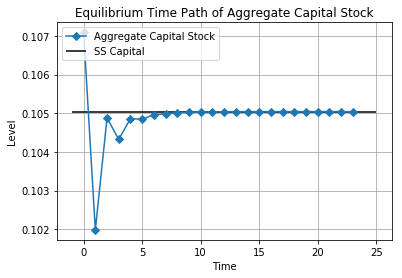

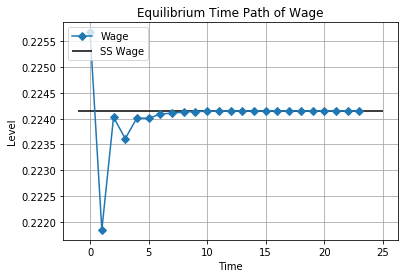

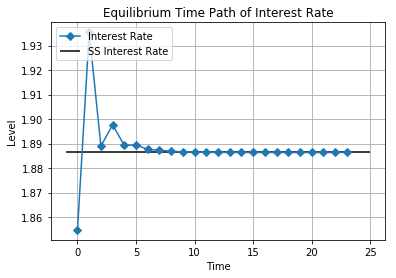

{'b_path': array([[0.02254154, 0.084552  ],
        [0.02931335, 0.07266953],
        [0.02734282, 0.07753592],
        [0.02826557, 0.07605686],
        [0.02800909, 0.07685031],
        [0.02816262, 0.07668193],
        [0.02813663, 0.07682473],
        [0.02816554, 0.0768163 ],
        [0.02816563, 0.07684638],
        [0.02817209, 0.07685063],
        [0.02817342, 0.07685819],
        [0.02817513, 0.07686068],
        [0.02817578, 0.07686287],
        [0.02817629, 0.07686386],
        [0.02817654, 0.07686455],
        [0.0281767 , 0.07686492],
        [0.02817679, 0.07686515],
        [0.02817685, 0.07686527],
        [0.02817688, 0.07686535],
        [0.0281769 , 0.07686539],
        [0.02817691, 0.07686542],
        [0.02817691, 0.07686543],
        [0.02817678, 0.07686542],
        [0.02817386, 0.0768648 ],
        [0.02810627, 0.07685051],
        [0.0265673 , 0.07652067],
        [0.        , 0.06894938],
        [0.        , 0.        ],
        [0.        , 0.        ]]),
 '

In [32]:
xi = 0.2
TPI_tol = 1e-8
SS_tol = 1e-8
params = (beta, sigma, xi, nvec, L, A, alpha, delta, SS_tol)
T = 25
TPI_output = get_TPI(params, T, SS_tol, TPI_tol, TPI_graph=True)
TPI_output

#### Part c (i) Periods it take for economy to get within 0.00001 of SS:

In [33]:
K_path = TPI_output['K_path']
K_bar = TPI_output['K_bar']
Loc = np.where(np.abs(K_path - K_bar) < .00001)[0]
Loc[0]

11

#### Part c (ii) Period after which aggregate capital stock is never again farther than 0.00001 away from SS:

In [34]:
Loc = np.where(np.abs(K_path - K_bar) < .00001)[0]
Loc

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

Therefore, 11